In [4]:
import bhnerf
import bhnerf.constants as consts
import numpy as np
from astropy import units
import ehtim as eh
from flax.training import checkpoints
import matplotlib.pyplot as plt

import importlib

In [5]:
"""
Generate synthetic observations of a hot-spot
"""
fov_M = 16.0
z_width = 4
rmax = fov_M/2
spin = 0.2
inclination = np.deg2rad(60.0)      
nt = 64
array = 'ngEHT'             
flux_scale = 0.1                    # scale image-plane fluxes to `reasonable` values in Jy
tstart = 2.0 * units.hour           # observation start time
tstop = tstart + 40.0 * units.min   # observation stop time

# Compute geodesics (see Tutorial1)
geos = bhnerf.kgeo.image_plane_geos(
    spin, inclination, 
    num_alpha=64, num_beta=64, 
    alpha_range=[-fov_M/2, fov_M/2],
    beta_range=[-fov_M/2, fov_M/2]
)
Omega = np.sign(spin + np.finfo(float).eps) * np.sqrt(geos.M) / (geos.r**(3/2) + geos.spin * np.sqrt(geos.M))
t_injection = -float(geos.r_o)
rmin = float(geos.r.min())

# Generate hotspot measurements (see Tutorial2) 
emission_0 = flux_scale * bhnerf.emission.generate_hotspot_xr(
    resolution=(64, 64, 64), 
    rot_axis=[0.0, 0.0, 1.0], 
    rot_angle=0.0,
    orbit_radius=5.5,
    std=0.7,
    r_isco=bhnerf.constants.isco_pro(spin),
    fov=(fov_M, 'GM/c^2')
)
obs_params = {
    'mjd': 57851,                       # night of april 6-7, 2017
    'timetype': 'GMST',
    'nt': nt,                           # number of time samples 
    'tstart': tstart.to('hr').value,    # start of observations
    'tstop': tstop.to('hr').value,      # end of observation 
    'tint': 30.0,                       # integration time,
    'array': eh.array.load_txt('../eht_arrays/{}.txt'.format(array))
}
obs_empty = bhnerf.observation.empty_eht_obs(**obs_params)
fov_rad = (fov_M * consts.GM_c2(consts.sgra_mass) / consts.sgra_distance.to('m')) * units.rad
psize = fov_rad.value / geos.alpha.size 
obs_args = {'psize': psize, 'ra': obs_empty.ra, 'dec': obs_empty.dec, 'rf': obs_empty.rf, 'mjd': obs_empty.mjd}
t_frames = np.linspace(tstart, tstop, nt)
image_plane = bhnerf.emission.image_plane_dynamics(emission_0, geos, Omega, t_frames, t_injection)
movie = eh.movie.Movie(image_plane, times=t_frames.value, **obs_args)
obs = bhnerf.observation.observe_same(movie, obs_empty, ttype='direct', seed=None)

2025-08-27 20:22:56.644253: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/srv/tmp/kyle/miniconda3/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Producing clean visibilities from movie with direct FT . . . 
Applying Jones Matrices to data . . . 
Adding thermal noise to data . . . 
Applying a priori calibration with estimated Jones matrices . . . 


In [ ]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(8,3.5))
ax[0].set_title('UV coverage')
ax[1].set_title('Visibility amplitudes')
bhnerf.observation.plot_uv_coverage(obs, ax=ax[0], cmap_ticks=[0,0.2, 0.4, 0.6], fontsize=11)
obs.plotall('uvdist', 'amp', axis=ax[1])
plt.tight_layout()

In [8]:
"""reload a pretrained network"""
chisqdata = eh.imaging.imager_utils.chisqdata_vis

checkpoint_dir = '/srv/tmp/kyle/bhnerf/checkpoints/tutorial4/recovery.vis.2025-08-05.09:51:12/'
predictor = bhnerf.network.NeRF_Predictor.from_yml(checkpoint_dir)
state = checkpoints.restore_checkpoint(checkpoint_dir, None)

params = state['params']
raytracing_args = bhnerf.network.raytracing_args(geos, Omega, t_injection, t_frames[0])

/srv/tmp/kyle/miniconda3/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [ ]:
"""Visualize the recovered emission from bhnerf"""
import jax.numpy as jnp

### render 3D static emission
emission_estimate = bhnerf.network.sample_3d_grid(predictor.apply, params, fov=fov_M)
bhnerf.visualization.ipyvolume_3d(emission_estimate, fov=fov_M, level=[0, 0.2, 0.7])
print(emission_estimate.shape)

### render 3D lensed emission
viz = bhnerf.visualization.VolumeVisualizer(width=64, height=64, samples=64)
viz.set_view(cam_r=37.0, domain_r=fov_M/2, azimuth=0.0, zenith=inclination, up=np.array([0.,0.,1.]))
img_approx = viz.render(emission_estimate/(emission_estimate.max()+1e-12), facewidth=fov_M, jit=True, bh_radius=2.0, linewidth=0.1, cmap='inferno')
img_approx = np.nan_to_num(img_approx, nan=0.0, posinf=1.0, neginf=0.0)
img_approx = np.clip(img_approx, 0.0, 1.0)

fig, ax = plt.subplots()
ax.imshow(img_approx, origin='lower', cmap='inferno')
ax.set_title("3D lensed render")
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(norm=norm, cmap='inferno')
fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label='normalized emission')
plt.tight_layout()
plt.show()

### render 2D image plane emission
t0 = t_frames[0]
img = bhnerf.network.image_plane_prediction(
    params, predictor.apply,
    t_frames=t0,
    **raytracing_args,
    t_units=None
)

alpha = np.asarray(geos.alpha)
beta = np.asarray(geos.beta)
extent = [alpha.min(), alpha.max(), beta.min(), beta.max()]

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(img, origin='lower', extent=extent, cmap='inferno', aspect='equal')
axes[0].set_title('I(α,β) @ t0'); axes[0].set_xlabel('α [M]'); axes[0].set_ylabel('β [M]')
plt.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

axes[1].imshow(np.log10(np.asarray(img)+1e-12), origin='lower', extent=extent, cmap='inferno', aspect='equal')
axes[1].set_title('log10 I'); axes[1].set_xlabel('α [M]'); axes[1].set_ylabel('β [M]')
plt.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()



In [ ]:
importlib.reload(bhnerf.uncertainty)
import bhnerf.uncertainty as unc

print(emission_estimate.shape)
print(emission_estimate[0:5, 0:5, 0:5])

unc.interpolation_check_scalar(emission_estimate, fov_M, title="Recovered emission interpolation check")

In [ ]:
"""initialize uncertainty class and params. we'll compute the uncertainty in the first frame and propagate forward in time"""
importlib.reload(bhnerf.uncertainty)
import bhnerf.uncertainty as unc

k = 0 # compute uncertainty at frame 0
times, sigma, A = unc.build_A_per_frame(obs, t_frames, movie.fovx(), movie.xdim)

A = A[k]
sigma = sigma[k]

print("\n----------full movie params----------")
for key in raytracing_args.keys():
    if key == "J":
        print("J:", {raytracing_args[key]})
    elif key == "t_injection":
        print("t_injection:", {raytracing_args[key]})
    else:
        print(f"{key} shape:",raytracing_args[key].shape)


forward_model = unc.make_forward_model(predictor.apply, params, t_frames[0], raytracing_args, A)
br_unc = unc.BayesRaysUncertaintyMapper(predictor.apply, params, forward_model, raytracing_args, t_frames[0], A, fov_M, z_width, grid_res=(16, 16, 16), lam=1e-6/64**3)

In [ ]:
"""compute the hessian"""
nvis = sigma.shape[0]
H, R_eff = br_unc.compute_hessian_diag(sigma.reshape(-1), batch_size=1)
V = br_unc.get_covariance(H, nvis=nvis)

print("-"*20)
print("H MATRIX:", H, "SHAPE:", H.shape)
print("V MATRIX:", V, "SHAPE:", V.shape)

In [ ]:
"""render and visualize 3D uncertainty (static)"""

level_norm = (0.0, 0.3, 0.6, 0.9)
#opacity = (0.00, 0.25, 0.3, 0.5)
#opacity = (0.2, 0.10, 0.05, 0.00)
opacity = (0.2, 0.05, 0.0, 0.00)
br_unc.render_uncertainty_3d(H, V, fov_M, cmap='plasma', level_norm=level_norm, opacity=opacity, resolution=128, squared_weights=False)


In [ ]:
"""inspect a 2D slice of the recovered uncertainty"""
import matplotlib.pyplot as plt
importlib.reload(bhnerf.uncertainty)
sigmas = br_unc.upsample(V, resolution=64, squared_weights=False)
sigmas = sigmas[None, ...]
print(sigmas.shape)

show_initial_covariance_slice(V, 64, sigmas, axis=2, rel_thresh=0.01)

In [ ]:
"""propagate uncertainty forward in time"""
br_unc.t_frames = t_frames
R = 128

var0 = br_unc.upsample(V, resolution=R)
sigma_ts = br_unc.propagate_positional_variance(sigma0_var=var0, t_frames=t_frames, fov_M=fov_M, 
R=128, spin=spin, M=1.0, rot_axis=(0.,0.,1.), chunk_pts=32768) # propagate forward in time according to the dynamics in emission.py

In [ ]:
"""render time dependent uncertainty"""
# for dynamic masking
network_movie = br_unc.build_emission_movie(t_frames=t_frames, fov_M=fov_M, R=R, spin=spin) 
# 0 out where there is no emission
masks = bhnerf.uncertainty.build_dynamic_mask(network_movie, relative_threshold=0.01) 
# mask, clip, log scale
sigma_ts_render = bhnerf.uncertainty.prepare_unc_for_render(sigma_ts, mask=masks) 

visualizer = bhnerf.visualization.VolumeVisualizer(R, R, R)
%matplotlib widget
anim = bhnerf.visualization.render_3d_movie(sigma_ts_render, t_frames, visualizer, cam_r=37.0, rmax=predictor.rmax, bh_radius=2.0, linewidth=0.1, cmap='plasma', azimuth=0, zenith=inclination, normalize=False)

In [ ]:
emission_anim = bhnerf.visualization.render_3d_movie(network_movie, t_frames, visualizer, cam_r=37.0, rmax=predictor.rmax, bh_radius=2.0, linewidth=0.1, cmap='inferno', azimuth=0, zenith=inclination, normalize=True, resolution=128)

In [ ]:
emission_anim.save('../results/bayesrays/3Dmovie_grid_res64_emission.mp4', 'ffmpeg', fps=20, bitrate=1e6)


In [ ]:
"""render the time propagated 2D uncertainty and movie on the z-axis"""
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def center_slice(vol4, fixed='z'):  # (nt,R,R,R) -> (nt,R,R)
    _, R, _, _ = vol4.shape
    mid = R // 2
    if fixed == 'x':
        slab = vol4[:, mid, :, :]
        return np.swapaxes(slab, 2, 1)
    elif fixed == 'y':
        slab = vol4[:, :, mid, :]
        return slab.transpose(0,2,1)
    else:
        slab = vol4[:, :, :, mid]
        return slab

movie_2d = center_slice(network_movie, fixed='z') # (nt,R,R)
unc_2d = center_slice(sigma_ts, fixed='z') # (nt,R,R)

# normalize for display
movie_disp  = movie_2d / (movie_2d.max(axis=(1,2), keepdims=True) + 1e-12)
uncertainty_disp = unc_2d / (unc_2d.max(axis=(1,2), keepdims=True) + 1e-12)

movie_da  = xr.DataArray(movie_disp,  dims=('t','y','x'), coords={'t': t_frames})
unc_da = xr.DataArray(uncertainty_disp, dims=('t','y','x'), coords={'t': t_frames})

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
anim2d = bhnerf.visualization.animate_movies_synced(
    [movie_da, unc_da], axes=axes,
    cmaps=['afmhot', 'plasma'],
    titles=['Emission (slice)', 'Uncertainty (slice)'], 
    fps=20,
    output='../results/bayesrays/grid_res64_propagated_no_transpose.mp4'
)
for ax in axes: ax.axis('off')
plt.tight_layout()


In [ ]:
R = 64
def show_initial_covariance_slice(V_diag, R, network_movie, axis=2, rel_thresh=0.01, percent_clip=(1, 99)):
    var0 = br_unc.upsample(V_diag, resolution=R)
    sigma0 = np.sqrt(var0 + 1e-12)

    em0 = np.asarray(network_movie[0])
    m0 = em0 > (em0.max() * rel_thresh)

    mid = R // 2
    if axis == 0:
        em_sl   = em0[mid, :, :]
        sig_sl  = sigma0[mid, :, :]
        mask_sl = m0[mid, :, :]
    elif axis == 1:
        em_sl   = em0[:, mid, :]
        sig_sl  = sigma0[:, mid, :]
        mask_sl = m0[:, mid, :]
    else:
        em_sl   = em0[:, :, mid]
        sig_sl  = sigma0[:, :, mid]
        mask_sl = m0[:, :, mid]

    u = np.log10(sig_sl * mask_sl + 1e-12)
    vmin, vmax = np.nanpercentile(u[mask_sl], percent_clip) if mask_sl.any() else (u.min(), u.max())
    u_disp = np.clip(u, vmin, vmax)
    u_disp = (u_disp - vmin) / (vmax - vmin + 1e-12)

    em_disp = em_sl / (em_sl.max() + 1e-12)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    im0 = axes[0].imshow(em_disp, origin='lower', cmap='afmhot')
    axes[0].set_title('Emission t=0 (slice)')
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(u_disp, origin='lower', cmap='plasma')
    cs = axes[1].contour(em_disp, levels=[0.2, 0.4, 0.6, 0.8], colors='w', linewidths=0.6)
    axes[1].set_title('σ₀ (slice, log-scaled)')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    for ax in axes: ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()

    print(f"[debug] σ0 slice stats (masked): min={np.nanmin(u[mask_sl]):.3f}, max={np.nanmax(u[mask_sl]):.3f}, "
          f"clip=({vmin:.3f},{vmax:.3f}), coverage={mask_sl.mean():.4f}")
    
V = br_unc.get_covariance(H, nvis=sigma.shape[0])

show_initial_covariance_slice(V, R, network_movie, axis=2, rel_thresh=0.01)

In [9]:
"""initialize uncertainty class and params. we'll compute the uncertainty in the first frame and propagate forward in time"""
importlib.reload(bhnerf.uncertainty)
import bhnerf.uncertainty as unc

times, sigma, A = unc.build_A_per_frame(obs, t_frames, movie.fovx(), movie.xdim)

print("\n----------full movie params----------")
for key in raytracing_args.keys():
    if key == "J":
        print("J:", {raytracing_args[key]})
    elif key == "t_injection":
        print("t_injection:", {raytracing_args[key]})
    else:
        print(f"{key} shape:",raytracing_args[key].shape)


#forward_model = unc.make_forward_model_all_frames(predictor.apply, params, t_frames, raytracing_args, A)
br_unc = unc.BayesRaysUncertaintyMapper(predictor.apply, params, None, raytracing_args, t_frames, A, fov_M, z_width, grid_res=(16, 16, 16), lam=1e-6/64**3)

Splitting Observation File into 64 times

----------full movie params----------
coords shape: (3, 64, 64, 100)
Omega shape: (64, 64, 100)
J: {1.0}
g shape: (64, 64, 100)
dtau shape: (64, 64, 100)
Sigma shape: (64, 64, 100)
t_start_obs shape: ()
t_geos shape: (64, 64, 100)
t_injection: {-1000.0}
Coords (bayesrays): (64, 64, 100, 3)
Coords min and max: 999.41284 -999.78613
Coords unit min, max: 0.9999999 0.0
Coords unit shape: (64, 64, 100, 3) Coords shape: (64, 64, 100, 3)


In [10]:
importlib.reload(bhnerf.uncertainty)
import pickle as pkl
import bhnerf.uncertainty as unc
print(sigma.shape)
#H, R_eff = br_unc.compute_hessian_diag_all(sigma, batch_size=1)

H = pkl.load(open('../results/bayesrays/hessian_diag.pkl', 'rb'))
R_eff= pkl.load(open('../results/bayesrays/nvis.pkl', 'rb'))

(64, 153)


In [ ]:
"""compute the hessian"""
from tqdm.auto import tqdm
import jax.numpy as jnp

H = jnp.zeros((br_unc.P,), dtype=jnp.float32)
for f in tqdm(range(len(br_unc.t_frames)), desc='frame'):
    br_unc.forward_model = unc.make_forward_model(predictor.apply, params, br_unc.t_frames[f], raytracing_args, A[f])
    H += br_unc.compute_hessian_diag(sigma[f], batch_size=1)[0]

In [24]:
"""render and visualize 3D uncertainty (static)"""
importlib.reload(bhnerf.visualization)
import bhnerf.visualization as vis

nvis = sigma.shape[0]*len(br_unc.t_frames)
V = br_unc.get_covariance(H, nvis=nvis)

#level_norm = (0.0, 0.3, 0.6, 1)
#level_norm = np.linspace(0, 1, 10)
level_norm = (0.0, 0.3, 0.6, 0.9, 1.0)
opacity = (0.4, 0.4, 0.4, 0.0, 0.0)
#opacity = (0.00, 0.25, 0.3, 0.5)
#opacity = (0.2, 0.10, 0.05, 0.00)
#opacity = (0.8, 0.6, 0.4, 0.00)
#opacity = np.linspace(1, 0, 10)
#opacity = (0.00, 0.05, 0.10, 0.20)

uncertainty = br_unc.prep_uncertainty_3d(H, V, resolution=64, squared_weights=False)
#br_unc.render_uncertainty_3d_ipv(uncertainty, fov_M, level_norm=level_norm, opacity=opacity)

fig = vis.render_uncert_volume_plotly(uncertainty, fov_M, level_norm=level_norm, opacity=opacity)


computing covariance matrix with lambda: 3.814697265625e-12


/srv/tmp/kyle/bhnerf/bhnerf/visualization.py:378: AccessorRegistrationWarning:

registration of accessor <class 'bhnerf.visualization._VisualizationAccessor'> under name 'visualize' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.



opacityscale used: ([0.0, 0.4], [0.3, 0.4], [0.6, 0.4], [0.9, 0.0], [1.0, 0.0])
isomin/isomax: 0.0 1.0


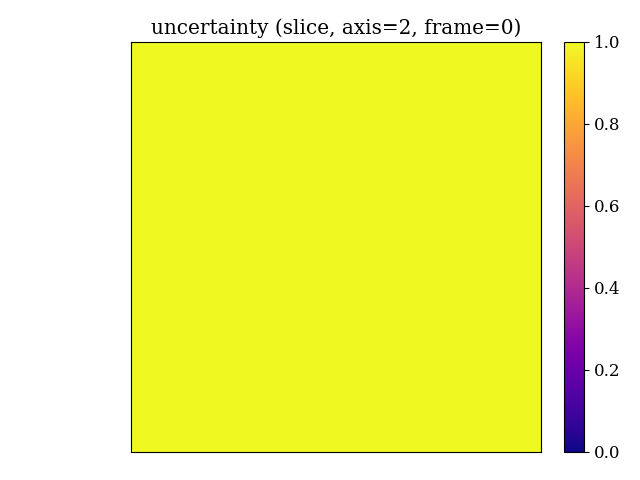

In [ ]:
def uncertainty_slice(uncertainty, axis=2, fps=20):
    import matplotlib.animation as animation

    R = uncertainty.shape[axis]
    vmin = uncertainty.min()
    vmax = uncertainty.max()
    def get_slice(i):
        if axis == 0:
            sig_sl  = uncertainty[i, :, :]
        elif axis == 1:
            sig_sl = uncertainty[:, i, :]
        else:
            sig_sl = uncertainty[:, :, i]
        return sig_sl
    
    fig, ax = plt.subplots()
    im1 = ax.imshow(get_slice(0), origin='lower', cmap='plasma', vmin=vmin, vmax=vmax)
    ax.set_title('uncertainty (slice, axis={}, frame={})'.format(axis, 0))
    fig.colorbar(im1, fraction=0.046, pad=0.04)
    ax.set_xticks([]); ax.set_yticks([])
    fig.tight_layout()

    def animate(i):
        sig_sl = get_slice(i)
        im1.set_array(sig_sl)
        ax.set_title('uncertainty (slice, axis={}, frame={})'.format(axis, i))
        return [im1]

    anim = animation.FuncAnimation(fig, animate, frames=range(R), interval=1e3 / fps)

    return anim
%matplotlib widget
anim = uncertainty_slice(uncertainty, axis=2)
plt.show()
anim.save('../results/bayesrays/3D_uncertainty_slice_zaxis.mp4', 'ffmpeg', fps=20, bitrate=1e6)